Paper link: https://arxiv.org/pdf/1901.09311

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, floor

In [2]:

def generate_better_structured_mdp(num_states=30, num_actions=4, spread=3, goal_states=[25, 29], seed=None):
    if seed is not None:
        np.random.seed(seed)

    P = np.zeros((num_states, num_actions, num_states))
    R_ = np.zeros((num_states, num_actions))

    for s in range(num_states):
        for a in range(num_actions):
            # Bias transitions depending on action (e.g., left, right, stay, jump)
            if a == 0:  # move left
                center = max(0, s - 1)
            elif a == 1:  # move right
                center = min(num_states - 1, s + 1)
            elif a == 2:  # stay
                center = s
            else:  # jump to random goal
                center = np.random.choice(goal_states)

            indices = np.arange(num_states)
            weights = np.exp(-((indices - center) ** 2) / (2 * spread ** 2))
            weights /= weights.sum()
            P[s, a] = weights

            # Rewards: high reward at goal states, small negative elsewhere to encourage shorter paths
            expected_next_state = np.argmax(weights)
            if expected_next_state in goal_states:
                R_[s, a] = 1.0 - np.random.uniform(0, 0.05)  # goal reward
            else:
                R_[s, a] = -0.01 - np.random.uniform(0, 0.01)  # small step cost

    return P, R_

P, R_ = generate_better_structured_mdp(seed=42)

num_states, num_actions, _ = P.shape

def get_next_state(state, action):
    return np.random.choice(num_states, p=P[state, action])

def get_reward(state, action):
    return R_[state, action]


In [4]:
def value_iteration(P, R, gamma=0.99, theta=1e-6):
    num_states, num_actions, _ = P.shape
    Q = np.zeros((num_states, num_actions))  # Initialize Q-values to zero

    while True:
        delta = 0
        Q_new = np.copy(Q)

        for s in range(num_states):
            for a in range(num_actions):
                Q_new[s, a] = R_[s, a] + gamma * np.dot(P[s, a], np.max(Q, axis=1))
        
        delta = np.max(np.abs(Q_new - Q))
        Q = Q_new

        if delta < theta:
            break

    return Q
Q_optimal = value_iteration(P, R_, gamma=0.9)


In [5]:
delta = 0.01
gamma = 0.9
eps = (1-gamma)*5

In [6]:
Q = np.ones((num_states, num_actions))*(1/(1-gamma))
Q_hat = np.ones((num_states, num_actions))*(1/(1-gamma))
N = np.zeros((num_states, num_actions))
R = ceil(np.log(3/(eps*(1-gamma)))/(1-gamma))
eps_2 = eps / 3
L = int(floor(np.log(R) / np.log(2)))
eps_L = (1/2**(L+2))*eps_2*((-np.log(1-gamma))**-1)
M = np.max([10, int(ceil(-2*np.log(eps_L*(1-gamma))))])
eps_1 = eps / (24*R*M*np.log(1/(1-gamma)))
H = int(np.ceil(np.log(1/((1-gamma)*eps_1)) / np.log(1/gamma)))
c_2 = (1-gamma)/10
Tmax = 100000
def l_k(k, S=num_states, A=num_actions, delta=delta):
    return np.log(S*A*(k+1)*(k+2)/delta)
def alpha_k(k, H):
    return (H+1)/(H+k)

In [7]:
errors = {'ucb':[], 'eps-greedy':[]}
policy_mismatch = {"ucb":[], 'eps-greedy':[]}

In [8]:
optimal_policy = np.argmax(Q_optimal, axis=-1)

In [9]:
s = 0
for t in range(1, Tmax+1):
    q_values = Q_hat[s]
    max_value = np.max(q_values)
    best_actions = np.flatnonzero(q_values == max_value)
    a = np.random.choice(best_actions)
    s_ = get_next_state(s, a)
    r = get_reward(s, a)
    N[s, a] = N[s, a] + 1
    k = N[s, a]
    b_k = (c_2/(1-gamma))*np.sqrt(H*l_k(k)/k)
    # b_k = 0
    V_hat = np.max(Q_hat[s_])
    alpha = alpha_k(k, H)
    Q[s, a] = (1 - alpha)*Q[s, a] + alpha*(r + b_k + gamma*V_hat) 
    Q_hat[s, a] = min(Q_hat[s, a], Q[s, a])
    s = s_    
    error = np.mean(np.abs(Q_optimal - Q))
    errors['ucb'].append(error)
    policy_mismatch['ucb'].append(np.sum(optimal_policy != np.argmax(Q, axis=-1)))
    

In [10]:
Q_ucb = Q.copy()

In [11]:
eps = 0.2
s = 0
Q = np.zeros((num_states, num_actions))
alpha = 0.01
for t in range(1, Tmax + 1):
    q_values = Q[s]

    if np.random.rand() < eps:
        a = np.random.choice(len(q_values))  # Explore
    else:
        max_value = np.max(q_values)
        best_actions = np.flatnonzero(q_values == max_value)
        a = np.random.choice(best_actions)  # Exploit with tie-breaking

    s_ = get_next_state(s, a)
    r = get_reward(s, a)

    # alpha = (H + 1) / (H + t)  
    V_hat = np.max(Q[s_])
    Q[s, a] = (1 - alpha) * Q[s, a] + alpha * (r + gamma * V_hat)

    s = s_
    error = np.mean(np.abs(Q_optimal - Q))
    errors['eps-greedy'].append(error)
    policy_mismatch['eps-greedy'].append(np.sum(optimal_policy != np.argmax(Q, axis=-1)))


In [12]:
Q_eps = Q.copy()

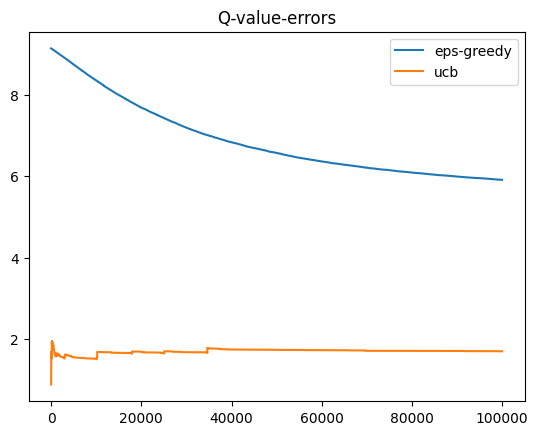

In [18]:
plt.title('Q-value-errors')
plt.plot(errors['eps-greedy'], label='eps-greedy')
plt.plot(errors['ucb'], label='ucb')
plt.legend()
plt.show()

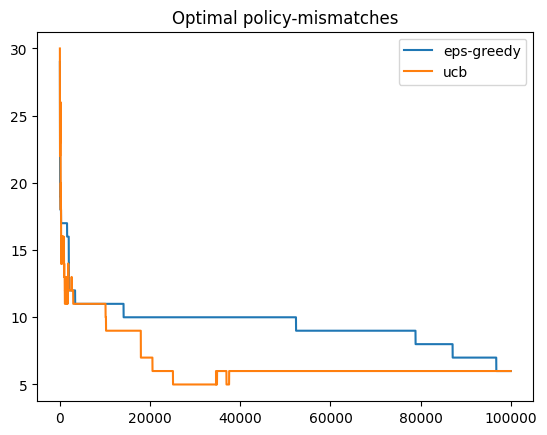

In [19]:
plt.title('Optimal policy-mismatches')
plt.plot(policy_mismatch['eps-greedy'], label='eps-greedy')
plt.plot(policy_mismatch['ucb'], label='ucb')
plt.legend()
plt.show()

In [15]:
np.argmax(Q_ucb,axis=-1)

array([1, 3, 3, 3, 2, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 2, 3, 3, 3, 2], dtype=int64)

In [16]:
np.argmax(Q_eps,axis=-1)

array([3, 3, 0, 3, 3, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 2], dtype=int64)

In [17]:
np.argmax(Q_optimal,axis=-1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 2, 3, 3, 3, 2], dtype=int64)